## Overview of the whole pipeline

Data Preprocessing:
- Acquisition
- Exploration and Cleaning
- Visualisation and Summary Statistics
- Feature Engineering
- Pre-processing for the specific computationals tools we have decided on

Other shit:

- Modelling and Evaluation
- Reporting, telling a story, connecting the dots


## Data Preprocessing

Acquire the Data
- Data folder. 
- Now we load files and folders.

In [1]:
import os
import pandas as pd
import numpy as np

data_dir = "Data/ml-latest-small"
movies_path = os.path.join(data_dir, "cleaned_movies.csv")
ratings_path = os.path.join(data_dir, "ratings.csv")
tags_path = os.path.join(data_dir, "cleaned_tags.csv")
links_path = os.path.join(data_dir, "cleaned_links.csv")

- Load the datasets into pandas DataFrames:

In [2]:
# Load the datasets into pandas DataFrames:
movies = pd.read_csv(movies_path)
ratings = pd.read_csv(ratings_path, usecols=['userId', 'movieId', 'rating']) # Discard timestamp column
tags = pd.read_csv(tags_path)
links = pd.read_csv(links_path)


In [14]:
## At a high level

# Movies 
# Print total number of movies
print("Total number of movies: ", len(movies))

# Print total number of ratings and users
#load ratings column 1 as numpy array
ratings_array = ratings.iloc[:, 1].values
#extract last userId to get total number of users
total_users = ratings['userId'].max()
print(total_users ," users gave ", str(len(ratings)) , " ratings.")

Total number of movies:  9742
610  users gave  100836  ratings.


- Visualise Movies CSV

In [15]:
print("Movies DataFrame:")
movies.head()


Movies DataFrame:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


- Visualise Links CSV

In [17]:
print("Links DataFrame:")
links.head()


Links DataFrame:


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


- Visualise Ratings CSV

In [18]:
print("Ratings DataFrame:")
ratings.head()


Ratings DataFrame:


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


- Visualise Tags CSV

In [19]:
print("Tags DataFrame:")
tags.head()

Tags DataFrame:


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


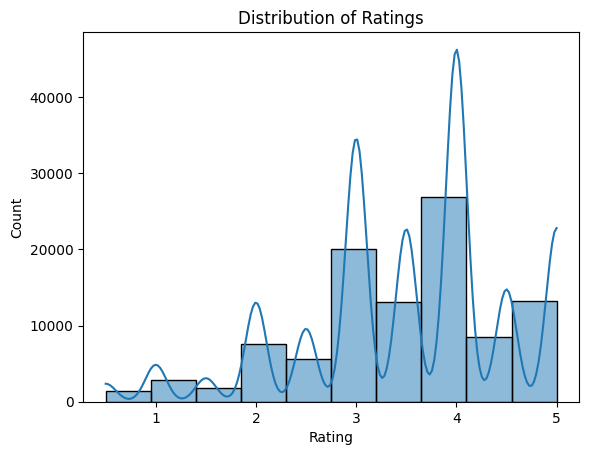

In [20]:
# Visualisations
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of Ratings
sns.histplot(ratings['rating'], bins=10, kde=True)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

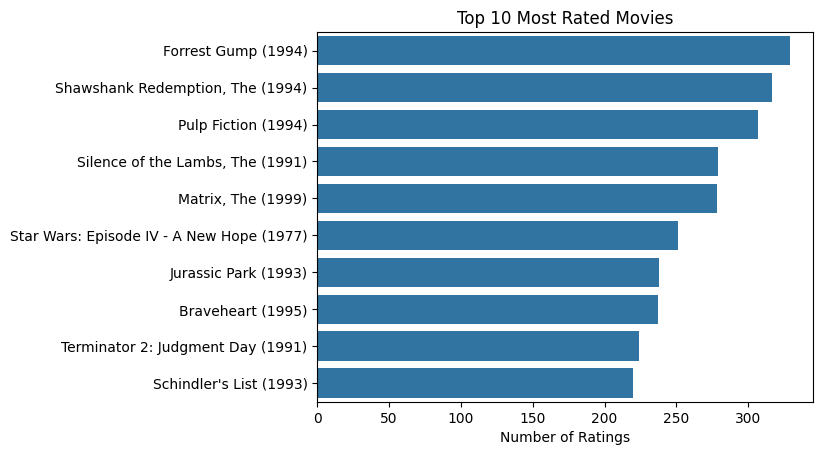

In [21]:
movie_ratings = ratings.groupby('movieId').agg(
    avg_rating=('rating', 'mean'),
    num_ratings=('rating', 'count')
).reset_index()

movie_ratings = movie_ratings.merge(movies, on='movieId')

top_movies = movie_ratings.sort_values('num_ratings', ascending=False).head(10)

sns.barplot(y='title', x='num_ratings', data=top_movies)
plt.title("Top 10 Most Rated Movies")
plt.xlabel("Number of Ratings")
plt.ylabel("")
plt.show()

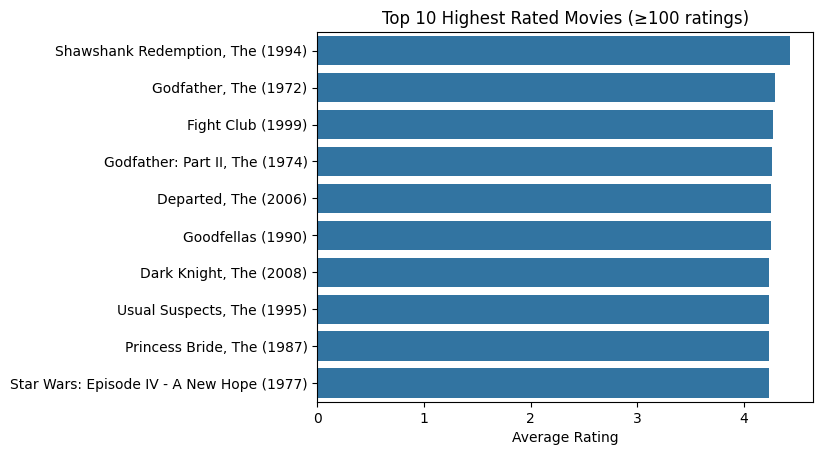

In [22]:
popular = movie_ratings[movie_ratings['num_ratings'] > 100]
top_rated = popular.sort_values('avg_rating', ascending=False).head(10)

sns.barplot(y='title', x='avg_rating', data=top_rated)
plt.title("Top 10 Highest Rated Movies (≥100 ratings)")
plt.xlabel("Average Rating")
plt.ylabel("")
plt.show()


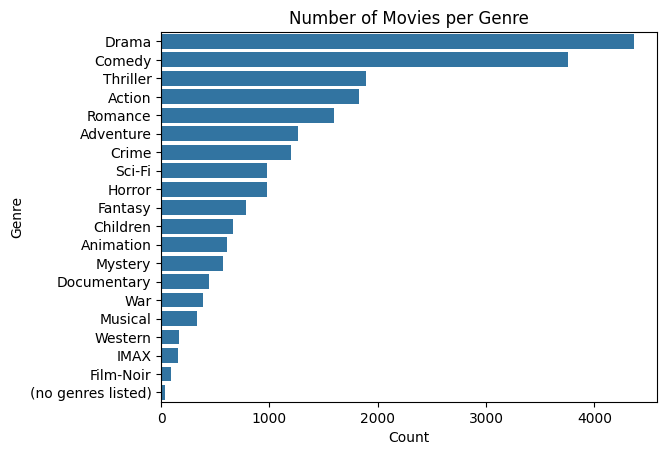

In [23]:
from collections import Counter

genre_counts = Counter(g for genres in movies['genres'] for g in genres.split('|'))
genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count'])

sns.barplot(y='Genre', x='Count', data=genre_df.sort_values('Count', ascending=False))
plt.title("Number of Movies per Genre")
plt.show()


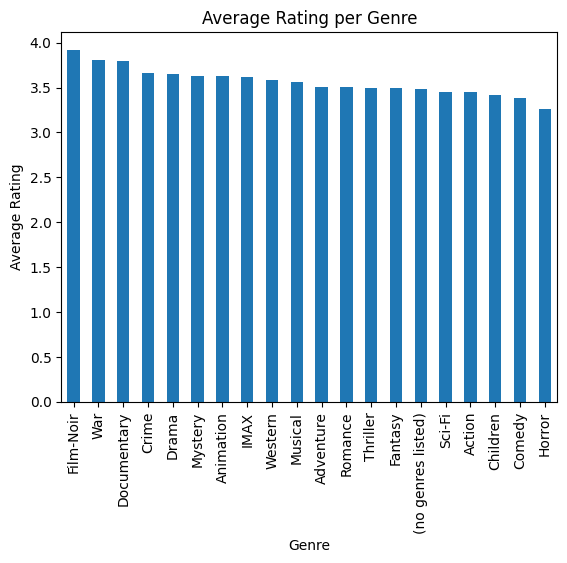

In [24]:
# Average rating per genre

movie_genres = movies.assign(Genre=movies['genres'].str.split('|')).explode('Genre')
genre_ratings = ratings.merge(movie_genres, on='movieId')
avg_genre_rating = genre_ratings.groupby('Genre')['rating'].mean().sort_values(ascending=False)

avg_genre_rating.plot(kind='bar')
plt.title("Average Rating per Genre")
plt.ylabel("Average Rating")
plt.show()

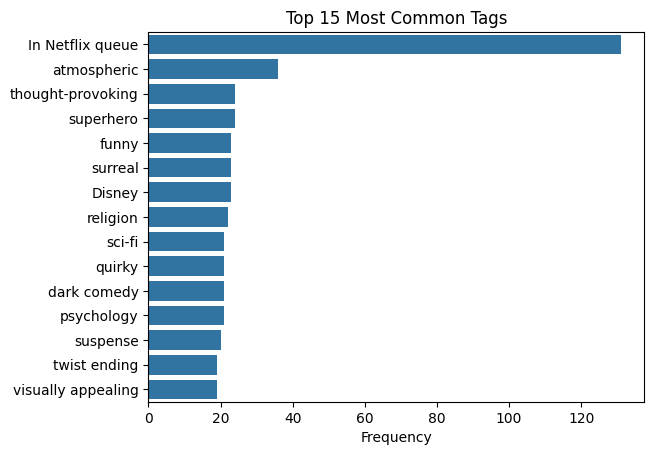

In [26]:
tag_counts = tags['tag'].value_counts().head(15)
sns.barplot(y=tag_counts.index, x=tag_counts.values)
plt.title("Top 15 Most Common Tags")
plt.xlabel("Frequency")
plt.ylabel("")
plt.show()

Show the sizes of each DataFrame:

In [3]:
# Show the sizes of each of the dataframe:
print(movies.info())
print(ratings.info())
print(tags.info())
print(links.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null 

# Apriori Algorithm

1. Generating the candidate 1-itemsets:

In [4]:
# 1. Calculate Total Users (Transactions)
total_users = ratings['userId'].nunique()

# Filter ratings first: Keep only rows where rating >= MIN_RATING
MIN_RATING = 4.0      # Only consider ratings >= 4.0
high_ratings = ratings[ratings['rating'] >= MIN_RATING]

# 2. Calculate Frequency (Raw Support) for each movie
# Count how many unique users rated each movie
movie_frequency = high_ratings.groupby('movieId')['userId'].nunique().rename('frequency')

# 3. Calculate Relative Support
# Support = (Number of users who rated the movie) / (Total number of users)
movie_support = (movie_frequency / total_users).rename('support')

# 4. Merge results with movie titles for readability
support_df = pd.merge(movies[['movieId', 'title']], movie_frequency, on='movieId', how='left')
support_df = pd.merge(support_df, movie_support, left_on='movieId', right_index=True, how='left')

# Fill NaNs for movies with 0 ratings
support_df['frequency'] = support_df['frequency'].fillna(0).astype(int)
support_df['support'] = support_df['support'].fillna(0.0)

# Sort by support descending to see top movies
support_df_sorted = support_df.sort_values(by='support', ascending=False)

# Display results
print(f"Total number of unique users: {total_users}\n")
print("Top 10 Movies by Support:")
print(support_df_sorted[['title', 'frequency', 'support']].head(10))

# Based on support of the 1-item groups
MIN_SUPPORT = 0.05 # Minimum support threshold (5% of total users)

# --- Frequent 1-Itemsets (L1) ---
# Filter support_df for movies meeting min_support
L1_df_sorted = support_df_sorted[support_df_sorted['support'] >= MIN_SUPPORT]
L1_movie_ids = L1_df_sorted['movieId'].tolist()

print(f"Found {len(L1_movie_ids)} frequent 1-itemsets (movies with support >= {MIN_SUPPORT*100}%).\n")

Total number of unique users: 610

Top 10 Movies by Support:
                                                  title  frequency   support
277                    Shawshank Redemption, The (1994)        274  0.449180
314                                 Forrest Gump (1994)        249  0.408197
257                                 Pulp Fiction (1994)        244  0.400000
510                    Silence of the Lambs, The (1991)        225  0.368852
1939                                 Matrix, The (1999)        222  0.363934
224           Star Wars: Episode IV - A New Hope (1977)        201  0.329508
2226                                  Fight Club (1999)        179  0.293443
461                             Schindler's List (1993)        175  0.286885
898   Star Wars: Episode V - The Empire Strikes Back...        168  0.275410
97                                    Braveheart (1995)        166  0.272131
Found 353 frequent 1-itemsets (movies with support >= 5.0%).



2. Generate candidate 2-Itemsets:

In [5]:
import itertools
from collections import defaultdict

# --- Generate Candidate 2-Itemsets (C2) ---
# Create all unique pairs from the frequent 1-itemsets
C2_candidates = list(itertools.combinations(L1_movie_ids, 2))
print(f"Generated {len(C2_candidates)} candidate 2-itemsets to check.\n")

# --- Count Support for Candidates ---
# Pre-process transactions for faster counting:
# Create a dictionary where keys are userIds and values are sets of movieIds they rated >= 4.0
user_transactions = high_ratings.groupby('userId')['movieId'].apply(set).to_dict()

# Initialize a counter for candidate pairs
candidate_counts = defaultdict(int)

# Count occurrences of each candidate pair in user transactions
for userId, rated_movies in user_transactions.items():
    for candidate in C2_candidates:
        # Check if both movies in the pair are in the user's rated movies
        if set(candidate).issubset(rated_movies):
            candidate_counts[candidate] += 1

# --- Filter to get Frequent 2-Itemsets (L2) ---
min_support_count = total_users * MIN_SUPPORT
L2_itemsets = []

for candidate, count in candidate_counts.items():
    if count >= min_support_count:
        support = count / total_users
        L2_itemsets.append({
            'movie_id_1': candidate[0],
            'movie_id_2': candidate[1],
            'frequency': count,
            'support': support
        })

# Convert to DataFrame for easy viewing and sorting
L2_df = pd.DataFrame(L2_itemsets)

# Merge with movie titles for readability
# Merge title for movie 1
L2_df = pd.merge(L2_df, movies[['movieId', 'title']], left_on='movie_id_1', right_on='movieId', how='left')
L2_df = L2_df.rename(columns={'title': 'movie_1_title'}).drop(columns='movieId')
# Merge title for movie 2
L2_df = pd.merge(L2_df, movies[['movieId', 'title']], left_on='movie_id_2', right_on='movieId', how='left')
L2_df = L2_df.rename(columns={'title': 'movie_2_title'}).drop(columns='movieId')

# Sort by support descending
L2_df_sorted = L2_df.sort_values(by='support', ascending=False)

print(f"Found {len(L2_df_sorted)} frequent 2-itemsets.\n")
print("Top 10 Frequent 2-Itemsets by Support:")
print(L2_df_sorted[['movie_1_title', 'movie_2_title', 'frequency', 'support']].head(10).to_string(index=False))

Generated 62128 candidate 2-itemsets to check.

Found 3703 frequent 2-itemsets.

Top 10 Frequent 2-Itemsets by Support:
                            movie_1_title                                         movie_2_title  frequency  support
         Shawshank Redemption, The (1994)                                   Forrest Gump (1994)        168 0.275410
         Shawshank Redemption, The (1994)                                   Pulp Fiction (1994)        158 0.259016
                      Pulp Fiction (1994)                      Silence of the Lambs, The (1991)        152 0.249180
Star Wars: Episode IV - A New Hope (1977) Star Wars: Episode V - The Empire Strikes Back (1980)        144 0.236066
         Shawshank Redemption, The (1994)                      Silence of the Lambs, The (1991)        140 0.229508
                      Forrest Gump (1994)                                   Pulp Fiction (1994)        136 0.222951
         Shawshank Redemption, The (1994)                           

3. Generate candidate 3-itemsets:

In [6]:
# --- Generate Candidate 3-Itemsets (C3) ---
L2_pairs = [sorted([item['movie_id_1'], item['movie_id_2']]) for item in L2_itemsets]
L2_pairs.sort()

# Convert to a set for fast lookup during pruning
L2_pairs_set = set(tuple(pair) for pair in L2_pairs)

C3_candidates = set()
for i in range(len(L2_pairs)):
    for j in range(i + 1, len(L2_pairs)):
        # Join step: If first items match ( [A, B] and [A, C] )
        if L2_pairs[i][0] == L2_pairs[j][0]:
            # Create candidate by union: {A, B, C}
            candidate = tuple(sorted(set(L2_pairs[i]) | set(L2_pairs[j])))

            # Prune step: Check if ALL size-2 subsets are frequent
            is_valid = True
            for subset in itertools.combinations(candidate, 2):
                if tuple(sorted(subset)) not in L2_pairs_set:
                    is_valid = False
                    break

            if is_valid:
                C3_candidates.add(candidate)
        else:
            # Since L2_pairs is sorted, if first items don't match anymore,
            # we can break the inner loop early for efficiency.
            break

# Convert back to list for the rest of your code
C3_candidates = list(C3_candidates)

print(f"Generated {len(C3_candidates)} candidate 3-itemsets to check.\n")

# --- Count Support for Candidates (C3) ---
# Initialize a counter for candidate triples
candidate_3_counts = defaultdict(int)

# Count occurrences of each candidate triple in user transactions
for userId, rated_movies in user_transactions.items():
    for candidate in C3_candidates:
        # Check if all 3 movies in the triple are in the user's rated movies
        if set(candidate).issubset(rated_movies):
            candidate_3_counts[candidate] += 1

# --- Filter to get Frequent 3-Itemsets (L3) ---
L3_itemsets = []

for candidate, count in candidate_3_counts.items():
    if count >= min_support_count:
        support = count / total_users
        L3_itemsets.append({
            'movie_id_1': candidate[0],
            'movie_id_2': candidate[1],
            'movie_id_3': candidate[2],
            'frequency': count,
            'support': support
        })

# Convert to DataFrame
L3_df = pd.DataFrame(L3_itemsets)

# Merge with movie titles for readability
# Merge title for movie 1
L3_df = pd.merge(L3_df, movies[['movieId', 'title']], left_on='movie_id_1', right_on='movieId', how='left')
L3_df = L3_df.rename(columns={'title': 'movie_1_title'}).drop(columns='movieId')
# Merge title for movie 2
L3_df = pd.merge(L3_df, movies[['movieId', 'title']], left_on='movie_id_2', right_on='movieId', how='left')
L3_df = L3_df.rename(columns={'title': 'movie_2_title'}).drop(columns='movieId')
# Merge title for movie 3
L3_df = pd.merge(L3_df, movies[['movieId', 'title']], left_on='movie_id_3', right_on='movieId', how='left')
L3_df = L3_df.rename(columns={'title': 'movie_3_title'}).drop(columns='movieId')

# Sort by support descending
L3_df_sorted = L3_df.sort_values(by='support', ascending=False)

print(f"Found {len(L3_df_sorted)} frequent 3-itemsets.\n")
print("Top 10 Frequent 3-Itemsets by Support:")
print(L3_df_sorted[['movie_1_title', 'movie_2_title', 'movie_3_title', 'frequency', 'support']].head(10).to_string(index=False))

Generated 47985 candidate 3-itemsets to check.

Found 10486 frequent 3-itemsets.

Top 10 Frequent 3-Itemsets by Support:
                                            movie_1_title                                         movie_2_title                                                                  movie_3_title  frequency  support
                                      Pulp Fiction (1994)                      Shawshank Redemption, The (1994)                                               Silence of the Lambs, The (1991)        108 0.177049
                Star Wars: Episode IV - A New Hope (1977) Star Wars: Episode V - The Empire Strikes Back (1980)                              Star Wars: Episode VI - Return of the Jedi (1983)        107 0.175410
                                      Pulp Fiction (1994)                      Shawshank Redemption, The (1994)                                                            Forrest Gump (1994)        106 0.173770
Lord of the Rings: The Fellowship o

4. Generate the Association Rules

In [7]:
# --- Configuration ---
MIN_CONFIDENCE = 0.5
rules = []

# --- Generate Rules from L2 (Pairs) ---
l1_support_dict = L1_df_sorted.set_index('movieId')['support'].to_dict()

for _, row in L2_df_sorted.iterrows():
    m1_id, m1_title = row['movie_id_1'], row['movie_1_title']
    m2_id, m2_title = row['movie_id_2'], row['movie_2_title']
    support_pair = row['support']

    # Rule 1: {Movie 1} -> {Movie 2}
    conf_1_to_2 = support_pair / l1_support_dict[m1_id]
    if conf_1_to_2 >= MIN_CONFIDENCE:
        lift = conf_1_to_2 / l1_support_dict[m2_id]
        rules.append({
            'antecedents': [m1_title],
            'consequents': [m2_title],
            'support': support_pair,
            'confidence': conf_1_to_2,
            'lift': lift,
            'type': 'L2'
        })

    # Rule 2: {Movie 2} -> {Movie 1}
    conf_2_to_1 = support_pair / l1_support_dict[m2_id]
    if conf_2_to_1 >= MIN_CONFIDENCE:
        lift = conf_2_to_1 / l1_support_dict[m1_id]
        rules.append({
            'antecedents': [m2_title],
            'consequents': [m1_title],
            'support': support_pair,
            'confidence': conf_2_to_1,
            'lift': lift,
            'type': 'L2'
        })

# --- Generate Rules from L3 (Triplets) ---
l2_support_dict = {}
for _, row in L2_df.iterrows():
    pair = tuple(sorted([row['movie_id_1'], row['movie_id_2']]))
    l2_support_dict[pair] = row['support']

for _, row in L3_df_sorted.iterrows():
    ids = [row['movie_id_1'], row['movie_id_2'], row['movie_id_3']]
    titles = [row['movie_1_title'], row['movie_2_title'], row['movie_3_title']]
    support_triplet = row['support']

    for i in range(3):
        ant_indices = [j for j in range(3) if j != i]
        ant_ids = sorted([ids[k] for k in ant_indices])
        ant_titles = [titles[k] for k in ant_indices]
        
        # Track consequent ID for lift calculation
        cons_id = ids[i]
        cons_title = [titles[i]]

        ant_support = l2_support_dict.get(tuple(ant_ids))
        if ant_support:
            confidence = support_triplet / ant_support
            if confidence >= MIN_CONFIDENCE:
                # Compute the lift
                lift = confidence / l1_support_dict[cons_id]
                rules.append({
                    'antecedents': ant_titles,
                    'consequents': cons_title,
                    'support': support_triplet,
                    'confidence': confidence,
                    'lift': lift,
                    'type': 'L3'
                })

# --- Display Results Sorted by Lift ---
rules_df = pd.DataFrame(rules)
# Sort by lift descending
rules_df_sorted_by_lift = rules_df.sort_values(by='lift', ascending=False)

print(f"Generated {len(rules_df)} rules with confidence >= {MIN_CONFIDENCE*100}%.\n")
print("Top 20 Rules by LIFT:")
print(rules_df_sorted_by_lift[['antecedents', 'consequents', 'support', 'confidence', 'lift', 'type']].head(20).to_string(index=False))

Generated 25226 rules with confidence >= 50.0%.

Top 20 Rules by LIFT:
                                                                                     antecedents                                                                                      consequents  support  confidence     lift type
                                                                               [Hot Fuzz (2007)]                                                                       [Shaun of the Dead (2004)] 0.052459    0.761905 8.769093   L2
                                                                      [Shaun of the Dead (2004)]                                                                                [Hot Fuzz (2007)] 0.052459    0.603774 8.769093   L2
[Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)]                                                 [Harry Potter and the Chamber of Secrets (2002)] 0.062295    0.655172 8.326149   L2
             

<!-- # K-Means Clustering -->

# K-Means Clustering

Create a movie corpus for each movie:

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Process Genres (MovieLens)
movies['genres_str'] = movies['genres'].str.replace('|', ' ')

# Process Tags (MovieLens)
tags['tag'] = tags['tag'].astype(str)
movie_tags = tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()

# Initial Merge
metadata = pd.merge(movies, movie_tags, on='movieId', how='left')
metadata['tag'] = metadata['tag'].fillna('')

# --- 2. Load & Process TMDB Metadata ---
tmdb_path = r"Data\TMDB-API\tmdb_movie_details.csv"
try:
    tmdb_data = pd.read_csv(tmdb_path)
    
    # Ensure 'movieId' is the same type for merging (usually int)
    metadata['movieId'] = metadata['movieId'].astype(int)
    tmdb_data['movieId'] = tmdb_data['movieId'].astype(int)

    # Merge TMDB data into metadata
    # We only keep useful text columns for clustering
    metadata = pd.merge(metadata, tmdb_data[['movieId', 'overview', 'genres_tmdb', 'release_date', 'original_language']], on='movieId', how='left') # 

    # Fill NaNs in new columns
    metadata['overview'] = metadata['overview'].fillna('')
    metadata['genres_tmdb'] = metadata['genres_tmdb'].fillna('')

    print("TMDB metadata merged successfully.")

except FileNotFoundError:
    print(f"Error: File not found at {tmdb_path}. Please check the path.")
    # Create empty columns if file is missing so script doesn't crash later
    metadata['overview'] = ''
    metadata['genres_tmdb'] = ''

# --- 3. Create RICH Content String ---
# Combine all text sources. You can weigh them by repeating important ones if needed.
metadata['content'] = (
    metadata['genres_str'] + ' ' +
    metadata['tag'] + ' ' +
    metadata['genres_tmdb'] + ' ' +  # Adding TMDB genres too for completeness
    metadata['overview'] + ' ' +  
    # metadata['release_date'].to_string() + ' ' +
    metadata['original_language']
)

# Clean up extra spaces created by empty strings
metadata['content'] = metadata['content'].str.replace(r'\s+', ' ', regex=True).str.strip()
metadata['content'] = metadata['content'].fillna('')

print("\nExample extended content data:")
# print(metadata.head(10))

metadata['content'][0]

TMDB metadata merged successfully.

Example extended content data:


"Adventure Animation Children Comedy Fantasy pixar pixar fun Family,Comedy,Animation,Adventure Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences. en"

In [9]:
# --- 2. TF-IDF Vectorization ---
# stop_words='english' removes common words like "the", "and", etc.
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(metadata['content'])

print(f"\nTF-IDF Matrix Shape: {tfidf_matrix.shape}")
# (Number of movies, Number of unique words in genres/tags)

# --- 3. K-Means Clustering ---
# Choosing k=20 as an arbitrary starting point for movie genres/types
NUM_CLUSTERS = 10
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42)
kmeans.fit(tfidf_matrix)

# Add cluster labels back to the dataframe
metadata['cluster'] = kmeans.labels_

# --- 4. View Results ---
# Show 5 random movies from a few clusters to see if they make sense
for i in range(10): # Just show first 3 clusters as examples
    print(f"\n--- Cluster {i} ---")
    print(metadata[metadata['cluster'] == i]['title'].sample(5, replace=True).values)


TF-IDF Matrix Shape: (9742, 28579)

--- Cluster 0 ---
['Return with Honor (1998)'
 'Dream of Light (a.k.a. Quince Tree Sun, The) (Sol del membrillo, El) (1992)'
 'Atomic Cafe, The (1982)' 'Senna (2010)'
 'Cave of Forgotten Dreams (2010)']

--- Cluster 1 ---
["Man Who Planted Trees, The (Homme qui plantait des arbres, L') (1987)"
 'Cat Soup (Nekojiru-so) (2001)'
 'Only Yesterday (Omohide poro poro) (1991)' 'Open Season (2006)'
 'Wallace & Gromit: A Close Shave (1995)']

--- Cluster 2 ---
['Goodbye Lover (1999)'
 'Maltese Falcon, The (a.k.a. Dangerous Female) (1931)'
 'Killing Me Softly (2002)' 'Rashomon (Rashômon) (1950)'
 'Number 23, The (2007)']

--- Cluster 3 ---
["Wayne's World (1992)" 'Major Payne (1995)'
 'What Men Still Talk About (2011)' 'Bring It On Again (2004)'
 'Asterix & Obelix vs. Caesar (Astérix et Obélix contre César) (1999)']

--- Cluster 4 ---
['Black Hawk Down (2001)' 'Ashes and Diamonds (Popiól i diament) (1958)'
 'Rambo III (1988)' 'Memphis Belle (1990)'
 'Rome, Op

In [11]:
import plotly.express as px

metadata_aligned = metadata.reset_index(drop=True)

# 1. Dimensionality Reduction using PCA (Same as before)
# The components array is already 0-indexed.
pca = PCA(n_components=2)
components = pca.fit_transform(tfidf_matrix.toarray())

# Create a DataFrame for plotting
pca_df = pd.DataFrame(data=components, columns=['PC1', 'PC2'])

# 2. Add features from the ALIGNED metadata DataFrame
pca_df['cluster'] = metadata_aligned['cluster'].astype(str)
pca_df['title'] = metadata_aligned['title']        # CORRECTED: Takes title from the ALIGNED metadata
pca_df['genres'] = metadata_aligned['genres']      # CORRECTED: Takes genres from the ALIGNED metadata

# --- 3. Interactive Plotting with Plotly Express (Your original code, now working) ---

fig = px.scatter(
    pca_df,
    x='PC1',
    y='PC2',
    color='cluster',
    hover_data=['title', 'genres'], # These columns now exist in pca_df
    title=f'K-Means Clustering (k={NUM_CLUSTERS}) visualized with PCA',
    color_discrete_sequence=px.colors.qualitative.Alphabet,
    opacity=0.6
)

# Customize axis labels to show explained variance
pc1_variance = pca.explained_variance_ratio_[0] * 100
pc2_variance = pca.explained_variance_ratio_[1] * 100

fig.update_layout(
    xaxis_title=f"Principal Component 1 ({pc1_variance:.2f}%)",
    yaxis_title=f"Principal Component 2 ({pc2_variance:.2f}%)",
    height=700
)

fig.show()